In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Embedding,Conv1D,LSTM
from sklearn.model_selection import train_test_split


In [ ]:
file_path="/content/a1_IMDB_Dataset.csv"

In [ ]:
#Loading data
data=pd.read_csv(file_path)

In [ ]:
data.shape

(50000, 2)

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Chekking for null values
data.isnull().sum()

,0
review,0
sentiment,0


<Axes: xlabel='sentiment', ylabel='count'>

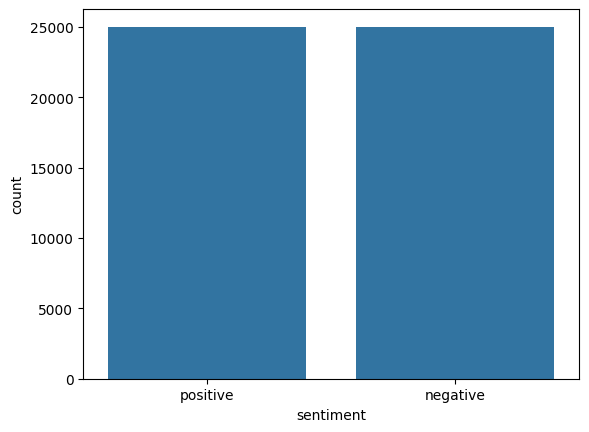

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=data)

# Data Processing

In [ ]:
data["review"][2]

# Text contains punctuations, brackets, HTML tags and numbers

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review
X[2]


'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# Converting sentiment labels to 0 & 1
y = data['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Preparing embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [ ]:
# Padding all reviews to fixed length 100
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92394, 100)

# Model Training With:

## Simple Neural Network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.6552 - loss: 0.6148 - val_acc: 0.7595 - val_loss: 0.5104
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.7939 - loss: 0.4443 - val_acc: 0.7651 - val_loss: 0.4926
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8149 - loss: 0.4083 - val_acc: 0.7628 - val_loss: 0.4983
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8342 - loss: 0.3854 - val_acc: 0.7591 - val_loss: 0.5095
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8485 - loss: 0.3618 - val_acc: 0.7626 - val_loss: 0.5198
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8504 - loss: 0.3521 - val_acc: 0.7544 - val_loss: 0.5323


In [ ]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7440 - loss: 0.5632


In [ ]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.562751054763794
Test Accuracy: 0.7462000250816345


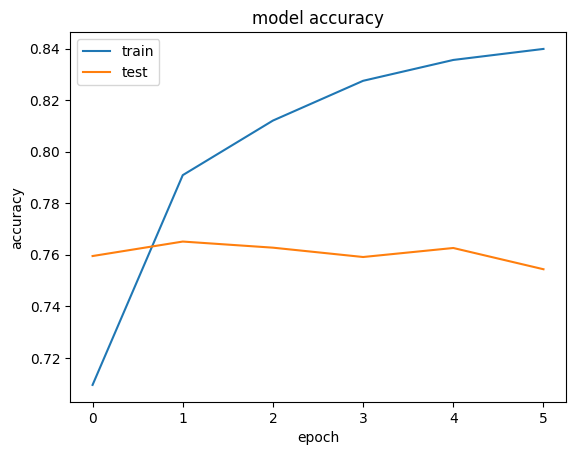

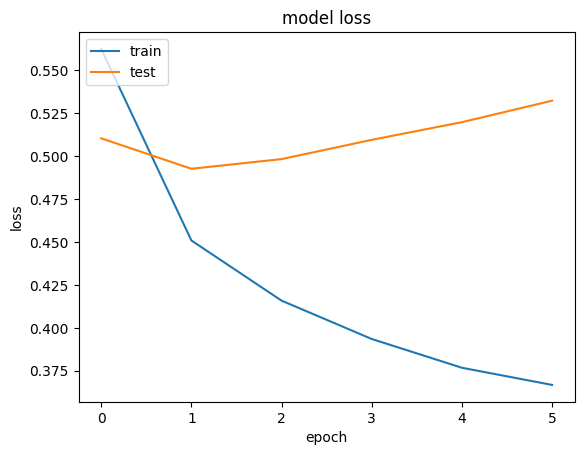

In [ ]:
# Model Performance Charts
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
# Neural Network architecture
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - acc: 0.7215 - loss: 0.5425 - val_acc: 0.8341 - val_loss: 0.3782
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - acc: 0.8533 - loss: 0.3460 - val_acc: 0.8304 - val_loss: 0.3757
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - acc: 0.8842 - loss: 0.2877 - val_acc: 0.8497 - val_loss: 0.3380
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - acc: 0.9152 - loss: 0.2347 - val_acc: 0.8349 - val_loss: 0.3732
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - acc: 0.9325 - loss: 0.2007 - val_acc: 0.8576 - val_loss: 0.3276
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - acc: 0.9551 - loss: 0.1576 - val_acc: 0.8530 - val_loss: 0.3340


In [ ]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.8554 - loss: 0.3356


In [ ]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34068435430526733
Test Accuracy: 0.8514000177383423


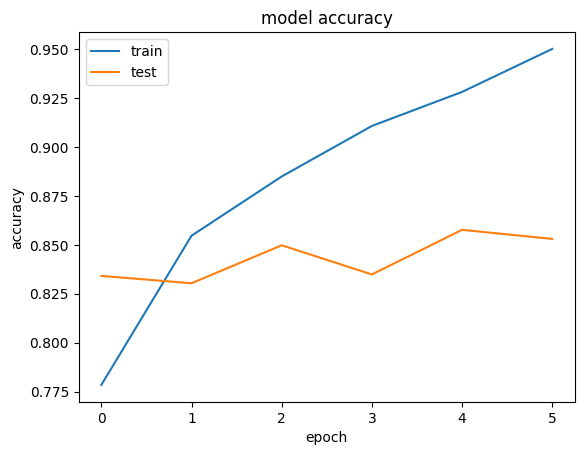

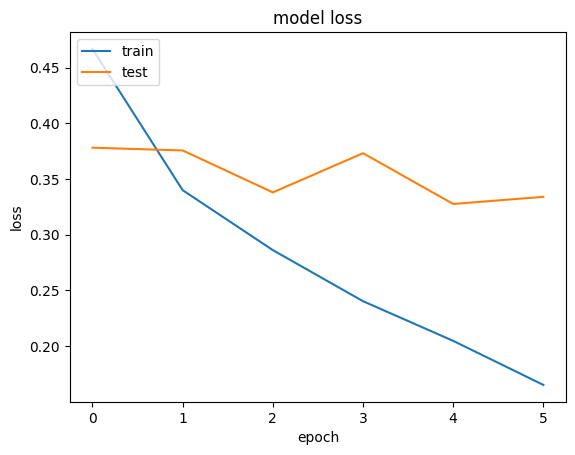

In [ ]:
# Model Performance Charts
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [ ]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 299ms/step - acc: 0.6897 - loss: 0.5724 - val_acc: 0.8045 - val_loss: 0.4599
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 352ms/step - acc: 0.8045 - loss: 0.4354 - val_acc: 0.8296 - val_loss: 0.3939
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 297ms/step - acc: 0.8306 - loss: 0.3796 - val_acc: 0.8511 - val_loss: 0.3456
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 299ms/step - acc: 0.8513 - loss: 0.3435 - val_acc: 0.8541 - val_loss: 0.3330
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step - acc: 0.8686 - loss: 0.3167 - val_acc: 0.8528 - val_loss: 0.3393
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 295ms/step - acc: 0.8683 - loss: 0.3109 - val_acc: 0.8497 - val_loss: 0.3290


In [ ]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - acc: 0.8574 - loss: 0.3218


In [ ]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3253191411495209
Test Accuracy: 0.8547000288963318


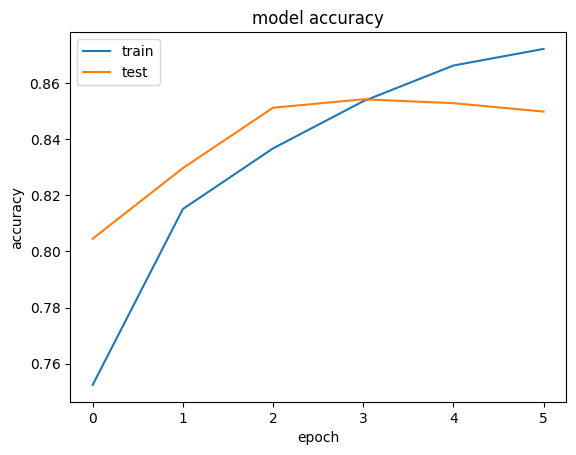

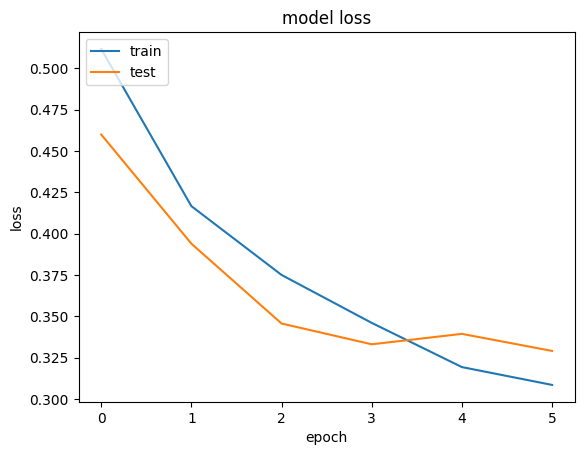

In [ ]:
# Model Performance Charts
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.keras")


# Making Predictions on Live IMDb data

In [ ]:
!ls # lists files in working directory

a1_IMDB_Dataset.csv   a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.855.keras
a2_glove.6B.100d.txt  c1_lstm_model_acc_0.855.h5  sample_data


In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")
sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


array([[0.89049226],
       [0.99165624],
       [0.0448025 ],
       [0.69235355],
       [0.96893924],
       [0.00938439]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.4
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,6.9
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
